In [22]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

#### Function to merge datasets

In [2]:
def mergedata(data1,data2):

    happiness_data=pd.read_csv(data1)
    health_expenditure=pd.read_csv(data2) 
    happiness_data.set_index('S_no', inplace=True)
    health_expenditure.set_index('S_no', inplace=True)
    world_happiness=happiness_data.drop(columns=['Economy (GDP per Capita)','Freedom','Generosity','Happiness Score'],axis=1)
    data=pd.merge(health_expenditure,world_happiness, on=["S_no", "S_no"]) 
    hypodata=data.drop(columns=['Year_y','Country_y'],axis=1)
    hypo3data=hypodata.rename(columns={'Year_x':'Year', 'Country_x':'Country','expenditure':'Expenditure'})
    return hypo3data

hypo3data=mergedata('happiness_world_data.csv','health_expenditure.csv')


In [3]:
MH_data= pd.read_csv('Mental Health Data 2016.csv')
nusers = MH_data['User_Id'].nunique()
MH_data=MH_data.rename(columns={'How many employees does your company or organization have?':'CompanySize','do you have a family history of mental illness?' : 'Family History of Mental Illness'})


#### Function to find the Null Values for the Mental Health Data and amend them

In [4]:
def FindNullValues(dataframe):
    """
    This function is used to find all the null vlaues in the Mental Health Dataset
    param: dataset
    return:column name with the number and percent of missing values
    """
    totalValues = dataframe.isnull().count()
    sumofnullValues = dataframe.isnull().sum()
    totalnullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percent = (sumofnullValues/totalValues).sort_values(ascending=False)
    missingData = pd.concat([totalnullValues, percent*100], axis=1, keys=['Missing Values', 'Percentage'])
    print(missingData.head(20))
   
    return missingData

noisyData = FindNullValues(MH_data)

                                                    Missing Values  Percentage
If maybe, what condition(s) do you believe you ...             692   78.995434
Is your primary role within your company relate...             649   74.086758
If yes, what condition(s) have you been diagnos...             522   59.589041
Have your observations of how another individua...             472   53.881279
If so, what condition(s) were you diagnosed with?              434   49.543379
What US state or territory do you live in?                     313   35.730594
What US state or territory do you work in?                     307   35.045662
Why or why not?                                                213   24.315068
Why or why not?.1                                              196   22.374429
Would you have been willing to discuss a mental...              96   10.958904
Did you hear of or observe negative consequence...              96   10.958904
Would you have been willing to discuss a mental...  

In [5]:
MH_data['What is your gender?'].unique()

array(['Male', 'M', 'female', 'Female', 'm', 'I identify as female.',
       'male', 'non-binary', 'Female assigned at birth ', 'Woman', 'man',
       'Male ', 'fm', 'f', 'F', 'Cis female ',
       'Female or Multi-Gender Femme', 'female/woman', 'Cis male',
       'Male.', 'Androgynous', nan, 'Female ', 'nb masculine',
       'Cisgender Female', 'Man', 'none of your business', 'cis male',
       'Genderfluid', 'Enby', 'genderqueer woman', 'female ', 'Queer',
       'Agender', 'Dude', 'woman', 'Male/genderqueer', 'fem', 'Nonbinary',
       'male ', 'Female (props for making this a freeform field, though)',
       ' Female', 'Cis Male', 'Male (trans, FtM)', 'Genderqueer',
       'cisdude', 'Genderflux demi-girl', 'cis man', 'Male (cis)'],
      dtype=object)

#### Function to clean the Column Gender 

In [6]:
def cleandata(dataframe):
    """
    This function is used for cleaning of the columns inside the dataset,we will clean the Gender column and merge all the other genders into one value
    param:dataset
    """
    genderDistribution = MH_data.loc[:, MH_data.columns.str.contains('gender|Gender', regex=True)]
    MH_data['Gender'] = genderDistribution.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    MH_data.loc[MH_data['Gender'].str.contains('Trans|them|trans|Undecided|Contextual|transgender|nb|unicorn|Unicorn|queer|NB|binary|Enby|Human|little|androgynous|Androgyne|Neutral|Agender|Androgynous|Androgynous|Fluid|GenderFluid|Genderflux|genderqueer|Genderqueer' , regex=True), 'Gender'] = 'Undecided'
    MH_data.loc[MH_data['Gender'].str.contains('Female|female|FEMALE|Woman|woman|w|womail|W|Cis female| Female (cis)|Cis Female|cis female|cis woman|F|f' , regex=True), 'Gender'] = 'Female'
    cond1 = MH_data['Gender']!='Female'
    cond2 = MH_data['Gender']!='Undecided'
    MH_data.loc[cond1 & cond2, 'Gender'] = 'Male'
    MH_data.drop(genderDistribution, axis=1, inplace=True)
    showGender = MH_data['Gender']
    print(showGender.unique())

cleandata(MH_data)

['Male' 'Female' 'Undecided']


In [7]:
MH_data['What is your age?'].unique()

array([ 39,  42,  30,  37,  44,  28,  34,  35,  52,  32,  31,  25,  27,
        36,  33,  29,  40,  46,  41,  24,  26,  23,  51,  45,  38,  21,
        55,  22,  49,  47,  50,  43,  57,  19, 323,  62,  53,  58,   3,
        54,  59,  63,  48,  74,  70,  20,  56], dtype=int64)

####  The approach I took instead of classifying a person having mental health issue or not is to provide scores to a particular user on the basis of the answers they have given to the survey


In [8]:
def givescore(dataframe):
    """
    This function calculates the MH_Score for every user
    param:dataset
    """
    for userid in range(1, nusers+1):
        df_user = MH_data[MH_data['User_Id']==userid]
        score = 0
        if  df_user['Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'].values =='Yes,I think they would' or df_user['Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'].values =='Yes, they would' or df_user['Do you currently have a mental health disorder?'].values =='Maybe' or df_user['Do you currently have a mental health disorder?'].values =='Possibly' or df_user['Have you ever sought treatment for a mental health issue from a mental health professional?'].values=='1' or df_user['Have you had a mental health disorder in the past?'].values =='Yes' or df_user['Have you had a mental health disorder in the past?'].values =='Possibly'or df_user['Have you had a mental health disorder in the past?'].values =='Maybe' or df_user['If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'].values =='Sometimes' or df_user['If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'].values =='Rarely' or df_user['If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'].values =='Sometimes' or df_user['If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'].values =='Rarely':
            score+=10
        if  df_user['Do you have a family history of mental illness?'].values =='Yes' or  df_user['How willing would you be to share with friends and family that you have a mental illness?'].values =='Not open at all' or df_user['Do you currently have a mental health disorder?'].values =='Yes' or df_user['If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'].values =='Often' or df_user['If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'].values =='Often' or df_user['Do you feel that being identified as a person with a mental health issue would hurt your career?'].values =='Yes, I think it would' or df_user['Do you feel that being identified as a person with a mental health issue would hurt your career?'].values =='Yes, it has':
            score+=15
        if df_user['Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?'].values =='Yes' or df_user['Would you feel comfortable discussing a mental health disorder with your coworkers?'].values =='Yes' :
            score+=5
        MH_data.loc[MH_data.User_Id == userid, ['MH_Score']]=score
        
givescore(MH_data)

In [9]:
MH_data.set_index('User_Id', inplace=True)
MH_data['MH_Score'].unique()

array([10., 15., 25., 30.,  5.,  0., 20., nan])

In [10]:
MH_data[(MH_data['What is your age?']<18)|(MH_data['What is your age?']>75)]

,Are you self-employed?,CompanySize,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",...,"If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?",What is your age?,What country do you live in?,What US state or territory do you live in?,What country do you work in?,What US state or territory do you work in?,Which of the following best describes your work position?,Do you work remotely?,Gender,MH_Score
User_Id,,,,,,,,,,,,,,,,,,,,,
565,0,100-500,1,NaN,Yes,No,I don't know,I don't know,I don't know,I don't know,...,Not applicable to me,323,United States of America,Oregon,United States of America,Oregon,Back-end Developer,Sometimes,Male,15.0
657,0,1000+,1,NaN,Yes,I am not sure,Yes,Yes,I don't know,Somewhat easy,...,Sometimes,3,Canada,NaN,Canada,NaN,Back-end Developer,Sometimes,Male,15.0


In [11]:
df=MH_data.drop([565,657])

### Hypothesis 1:Companies with a smaller number of people have less mental health issue.


Company Size vs MH Score,0.0,5.0,10.0,15.0,20.0,25.0,30.0
CompanySize,,,,,,,
100-500,0.052288,0.065359,0.058824,0.169935,0.019608,0.444444,0.189542
1000+,0.036496,0.058394,0.051095,0.094891,0.051095,0.379562,0.328467
26-100,0.073034,0.061798,0.050562,0.123596,0.050562,0.376404,0.264045
500-1000,0.089286,0.035714,0.000000,0.160714,0.053571,0.375000,0.285714


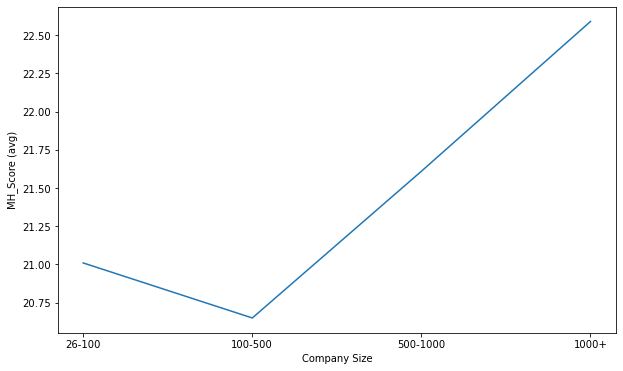

In [12]:
df['CompanySize'].value_counts()
value_count = round(df.groupby('CompanySize')['MH_Score'].mean(),2)
value_count
crossTab = pd.crosstab(df['CompanySize'],df['MH_Score'],
                       normalize = "index")
crossTab.columns.name = "Company Size vs MH Score"
display(crossTab)
fig, ax = plt.subplots(figsize=(10,6))
cats_vals = [value_count[2],value_count[0],value_count[3],value_count[1]]
cats = [value_count.index[2],value_count.index[0],value_count.index[3],value_count.index[1]]

plt.plot(cats, cats_vals)

plt.xlabel("Company Size")
plt.ylabel("MH_Score (avg)")

plt.show()

###  Hypothesis 2:Companies with large number of employees formally discuss mental health issues.

Mental Health discussion with Supervisor,Maybe,No,Yes
CompanySize,,,
100-500,0.348178,0.267206,0.384615
1000+,0.294118,0.380392,0.325490
26-100,0.359589,0.253425,0.386986
500-1000,0.400000,0.212500,0.387500


Text(0, 0.5, 'Discussing mental health disorder with Supervisor')

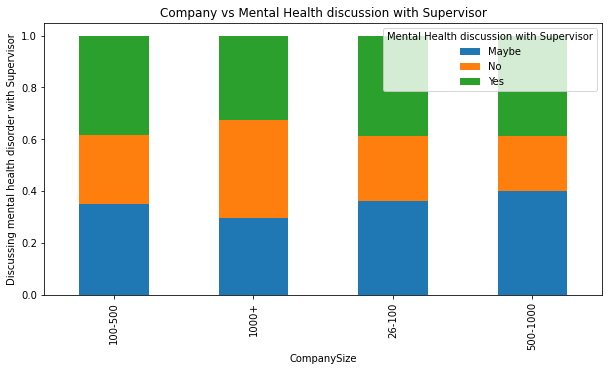

In [19]:
crossTab = pd.crosstab(df['CompanySize'],df['Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?'],
                       normalize = "index")
crossTab.columns.name = "Mental Health discussion with Supervisor"
display(crossTab)
crossTab.plot(kind="bar",stacked=True, figsize=(10,5))
plt.title( "Company vs Mental Health discussion with Supervisor")
plt.xlabel('CompanySize')
plt.ylabel('Discussing mental health disorder with Supervisor')



### Hypothesis 3:People in the age group 20-30 are most likely to discuss the mental health issues with the supervisor.

Discuss Mental Health with supervisor,Maybe,No,Yes
agerange,,,
18-29,0.348624,0.314985,0.336391
30-39,0.334165,0.259352,0.406484
40-49,0.360656,0.344262,0.295082
50-59,0.263158,0.263158,0.473684
60-75,0.250000,0.000000,0.750000


Text(0, 0.5, 'Discussing mental health disorder with Supervisor')

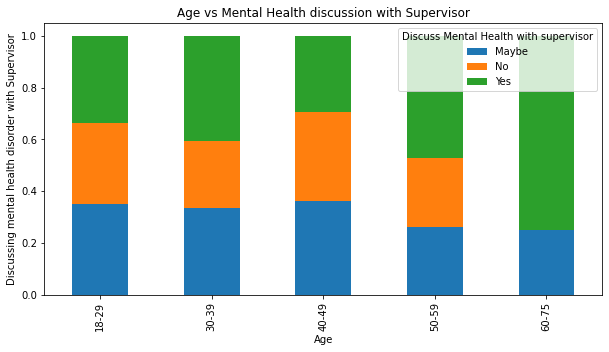

In [21]:
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-29', '30-39', '40-49', '50-59', '60-75']
age=df['What is your age?']
df['agerange'] = pd.cut(age, bins, labels = labels,include_lowest = True)
crossTab = pd.crosstab(df['agerange'],df['Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?'],
                       normalize = "index")
crossTab.columns.name = 'Discuss Mental Health with supervisor'
display(crossTab)

crossTab.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title( "Age vs Mental Health discussion with Supervisor")
plt.xlabel('Age')
plt.ylabel('Discussing mental health disorder with Supervisor')




### Hypothesis 4:Countries with High health expenditure improved the healthy score in the happiness report over the years.

In [15]:
MH_data['MH_Score'].sort_values(ascending=False).head(10)

User_Id
455    30.0
302    30.0
278    30.0
623    30.0
619    30.0
293    30.0
32     30.0
614    30.0
611    30.0
299    30.0
Name: MH_Score, dtype: float64

In [16]:
hypo3data1=MH_data.loc[[455,302,278,623,619,293,32,614,611,299]]
hypo3data1['What country do you work in?'].unique()

array(['United States of America', 'United Kingdom', 'Australia',
       'Netherlands', 'Switzerland'], dtype=object)

In [25]:
hypo3data.columns

Index(['Year', 'Country', 'Expenditure', 'Expentancy'], dtype='object')

In [17]:
UK_df=hypo3data[hypo3data['Country']=='United Kingdom']
Australia_df = hypo3data[hypo3data['Country']=='Australia']
Netherland_df=hypo3data[hypo3data['Country']=='Netherlands']
Switzerland_df=hypo3data[hypo3data['Country']=='Switzerland']

In [23]:
import plotly.express as px
def scatter_plot(dataframe, x, y, color, size, hover_name, log_x, size_max):
    fig = px.scatter(dataframe, x=x, y=y,
                     color=color, size=size,
                     hover_name=hover_name, log_x=log_x, size_max=size_max)

    return fig

In [29]:
x="Expentancy"
y="Year"
color="Country"
size= "Expenditure"
hover_name="Country"
log_x=True 
size_max=60

scatter_plot(hypo3data,x,y,color,size,hover_name,log_x,size_max)

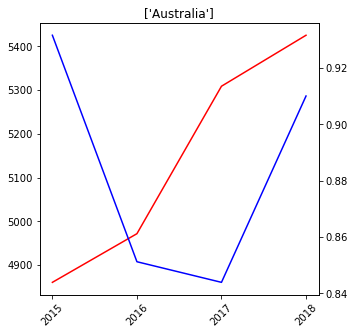

Red defines Health Expenditure
Blue defines Health Expentancy


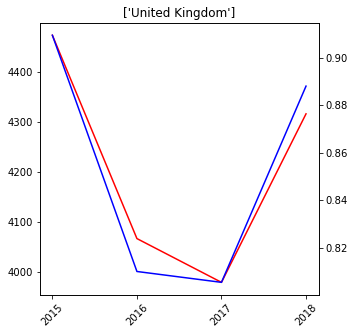

Red defines Health Expenditure
Blue defines Health Expentancy


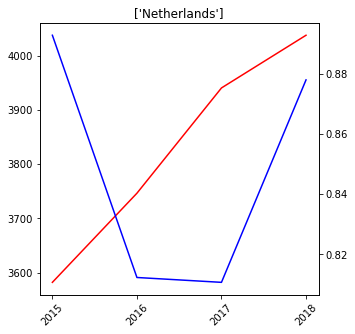

Red defines Health Expenditure
Blue defines Health Expentancy


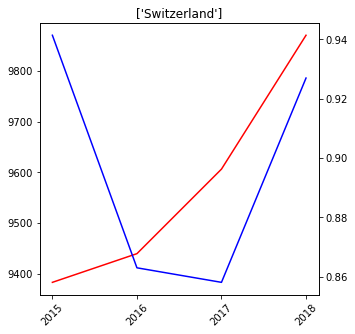

Red defines Health Expenditure
Blue defines Health Expentancy


In [18]:
def hypo3(dataset):
    fig,ax1=plt.subplots(figsize=(5,5))
    ax1.set_xticks(dataset['Year'])
    country=dataset['Country'].unique()
    ax2=ax1.twinx()
    ticks = plt.setp(ax1.get_xticklabels(),rotation=45)
    curve1=ax1.plot(dataset['Year'],dataset['Expenditure'],label="Health Expenditure", color='r')
    curve2=ax2.plot(dataset['Year'],dataset['Expentancy'],label="Health Life Expentancy",color='b')
    plt.title(country)
    plt.plot( )
    plt.show()
    print('Red defines Health Expenditure')
    print('Blue defines Health Expentancy')
    
hypo3(Australia_df)
hypo3(UK_df)
hypo3(Netherland_df)
hypo3(Switzerland_df)